In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import gzip

from cleverhans.dataset import MNIST
from cleverhans.utils import AccuracyReport
from cleverhans.utils_keras import cnn_model

from cleverhans_tutorials.mnist_tutorial_keras import *
from cleverhans.dataset import Dataset

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
%matplotlib inline 

## Setting up Tensorflow to Traininng

In [3]:
NB_EPOCHS = 6
BATCH_SIZE = 128
LEARNING_RATE = .001

# Object used to keep track of (and return) key accuracies
report = AccuracyReport()
# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)
# Force TensorFlow to use single thread to improve reproducibility
config = tf.ConfigProto(intra_op_parallelism_threads=1,
                      inter_op_parallelism_threads=1)

if keras.backend.image_data_format() != 'channels_last':
    raise NotImplementedError("this tutorial requires keras to be configured to channels_last format")

    # Create TF session and set as Keras backend session
sess = tf.Session(config=config)
keras.backend.set_session(sess)

## Loading Fashion-MNIST

In [4]:

fashion_mnist = keras.datasets.fashion_mnist
dataset_path = '/home/akushwaha/nfs/projects/fashion-mnist/data/fashion'
label_smoothing=0.1
labels = ['t_shirt_top', 'trouser', 'pullover', 'dress','coat',
          'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 28, 28) / 255.
    return images, labels

class FashionData(Dataset):
    """The FashionData dataset"""

    NB_CLASSES = 10

    def __init__(self, train_start=0, train_end=60000, test_start=0,
                 test_end=10000, center=False, max_val=1.):
        kwargs = locals()
        if '__class__' in kwargs:
            del kwargs['__class__']
        if 'max_val' in kwargs:
            del kwargs['max_val']
        super(FashionData, self).__init__(kwargs)
        (x_train, y_train), (x_test, y_test) = load_mnist(dataset_path, 'train'), load_mnist(dataset_path ,'t10k') 
        x_train, y_train, x_test, y_test  = self.transform_to_mnist_format(x_train, y_train, x_test, y_test)
        if center:
            x_train = x_train * 2. - 1.
            x_test = x_test * 2. - 1.
        x_train = x_train * max_val
        x_test = x_test * max_val

        self.x_train = x_train.astype('float32')
        self.y_train = y_train.astype('float32')
        self.x_test = x_test.astype('float32')
        self.y_test = y_test.astype('float32')

        
    def transform_to_mnist_format(self, x_train, y_train, x_test, y_test):
        x_train = np.expand_dims(x_train, -1)
        x_test = np.expand_dims(x_test, -1)
        y_train = to_categorical(y_train, num_classes=10)
        y_test = to_categorical(y_test, num_classes=10)
        return x_train, y_train, x_test, y_test

    def to_tensorflow(self, shuffle=4096):
        return (self.in_memory_dataset(self.x_train, self.y_train, shuffle),
                self.in_memory_dataset(self.x_test, self.y_test, repeat=False))

fashion_mnist = FashionData()
x_train, y_train = fashion_mnist.get_set('train')
x_test, y_test = fashion_mnist.get_set('test')

# Obtain Image Parameters
img_rows, img_cols, nchannels = x_train.shape[1:4]
nb_classes = y_train.shape[1]
y_train -= label_smoothing * (y_train - 1. / nb_classes)

# Define Keras model


In [7]:
# Define Keras model
model = cnn_model(img_rows=img_rows, img_cols=img_cols,
                  channels=nchannels, nb_filters=64,
                  nb_classes=nb_classes)

# To be able to call the model in the custom loss, we need to call it once
# before, see https://github.com/tensorflow/tensorflow/issues/23769
model(model.input)

<tf.Tensor 'sequential_1/activation_7/Softmax:0' shape=(?, 10) dtype=float32>

# Fast Gradient Sign Method for Adversarial Example Generation 

In [8]:
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils_keras import KerasModelWrapper

# Initialize the Fast Gradient Sign Method (FGSM) attack object
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap, sess=sess)
fgsm_params = {'eps': 0.3,
               'clip_min': 0.,
               'clip_max': 1.}


In [ ]:
learning_rate = LEARNING_RATE
nb_epochs = NB_EPOCHS
batch_size = BATCH_SIZE
label_smoothing = 0.1

# calculates the accuracy on adversarial example
dv_acc_metric = get_adversarial_acc_metric(model, fgsm, fgsm_params)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', adv_acc_metric]
)

# Train an MNIST model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=nb_epochs,
          validation_data=(x_test, y_test),
          verbose=2)

# Evaluate the accuracy on legitimate and adversarial test examples
_, acc, adv_acc = model.evaluate(x_test, y_test,
                                 batch_size=batch_size,
                                 verbose=0)
report.clean_train_clean_eval = acc
report.clean_train_adv_eval = adv_acc
print('Test accuracy on legitimate examples: %0.4f' % acc)
print('Test accuracy on adversarial examples: %0.4f\n' % adv_acc)

/nfs/projects/cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_max at 0x7f0c15d727b8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
/nfs/projects/cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_sum at 0x7f0c15d6ff28> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "


Train on 60000 samples, validate on 10000 samples
Epoch 1/6
 - 83s - loss: 0.8910 - acc: 0.8304 - adv_acc: 0.0921 - val_loss: 0.4078 - val_acc: 0.8743 - val_adv_acc: 0.0784
Epoch 2/6
 - 81s - loss: 0.7492 - acc: 0.8914 - adv_acc: 0.0703 - val_loss: 0.3674 - val_acc: 0.8842 - val_adv_acc: 0.0727
Epoch 3/6
 - 80s - loss: 0.7150 - acc: 0.9080 - adv_acc: 0.0597 - val_loss: 0.3648 - val_acc: 0.8966 - val_adv_acc: 0.0611
Epoch 4/6
 - 80s - loss: 0.6917 - acc: 0.9182 - adv_acc: 0.0575 - val_loss: 0.3346 - val_acc: 0.9019 - val_adv_acc: 0.0637
Epoch 5/6
 - 79s - loss: 0.6731 - acc: 0.9272 - adv_acc: 0.0524 - val_loss: 0.3505 - val_acc: 0.9019 - val_adv_acc: 0.0633
Epoch 6/6
 - 80s - loss: 0.6546 - acc: 0.9363 - adv_acc: 0.0480 - val_loss: 0.3235 - val_acc: 0.9081 - val_adv_acc: 0.0618
Test accuracy on legitimate examples: 0.9081
Test accuracy on adversarial examples: 0.0618



#### Test accuracy on **legitimate examples: 0.9081**
#### Test accuracy on **adversarial examples: 0.0618**


# Generating Adversarial Example

In [ ]:
from cleverhans.attacks.deep_fool import DeepFool
from cleverhans.attacks.carlini_wagner_l2 import CarliniWagnerL2
from cleverhans.attacks.spatial_transformation_method import SpatialTransformationMethod
from cleverhans.attacks.projected_gradient_descent import ProjectedGradientDescent

def generate_adversarial_example(keras_model_wrap, attack_algo, **kwargs):
    # Instantiate the attack model
    attack = attack_algo(keras_model_wrap, sess=sess)
    # Generate adversarial examples
    x_adv = attack.generate(model.input, **kwargs)
    return x_adv


def plot_n_examples(adv_transformed, clean_x, adv_x,  n=10):
    f, axarr = plt.subplots(n, 2, figsize=(15,15))

    import random
    for counter in range(n):
        i = random.randint(0, len(adv_transformed) - 1)


        data = x_train[i].reshape(28, 28)* 255
        axarr[counter, 0].imshow(data, interpolation='gaussian', cmap='gray')
        axarr[counter, 0].set_title(labels[clean_x[i]])

        data = adv_transformed[i].reshape(28, 28) * 255
        axarr[counter, 1].imshow(data,interpolation='gaussian', cmap='gray')
        axarr[counter, 1].set_title(labels[adv_x[i]])


### Fast Gradient Sign Method (FGSM)

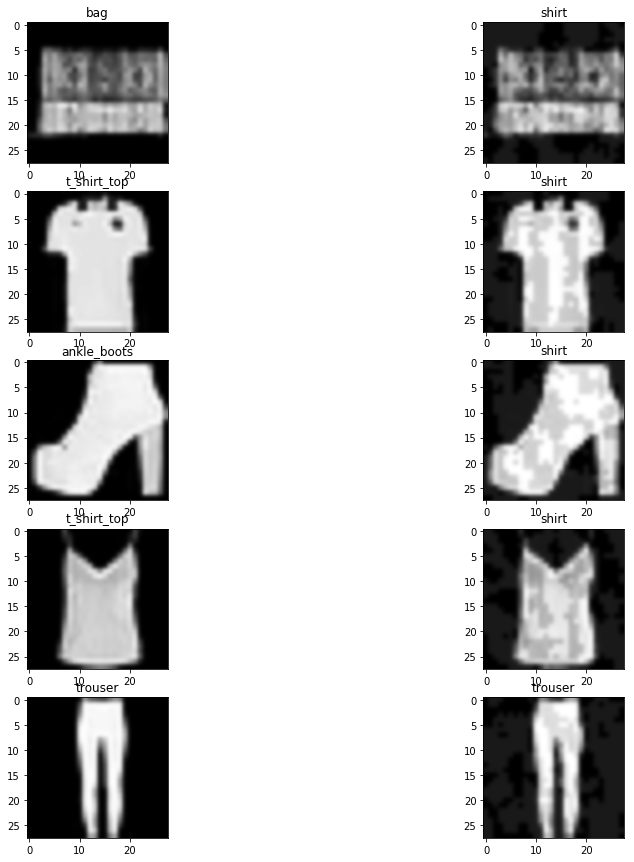

In [ ]:
fgsm_params = {'eps': 0.1,
               'clip_min': 0.,
               'clip_max': 1.}

x_adv = generate_adversarial_example(wrap, FastGradientMethod, **fgsm_params )
adv_res = x_adv.eval(session=sess, feed_dict={model.input:x_train[:400]}) # Convert to numpy matrix
adv_results = model.predict_classes(adv_res)
clean_results = model.predict_classes(x_train[:400])
plot_n_examples(adv_res, clean_results, adv_results, n = 5)

### Spatial Transformation Method

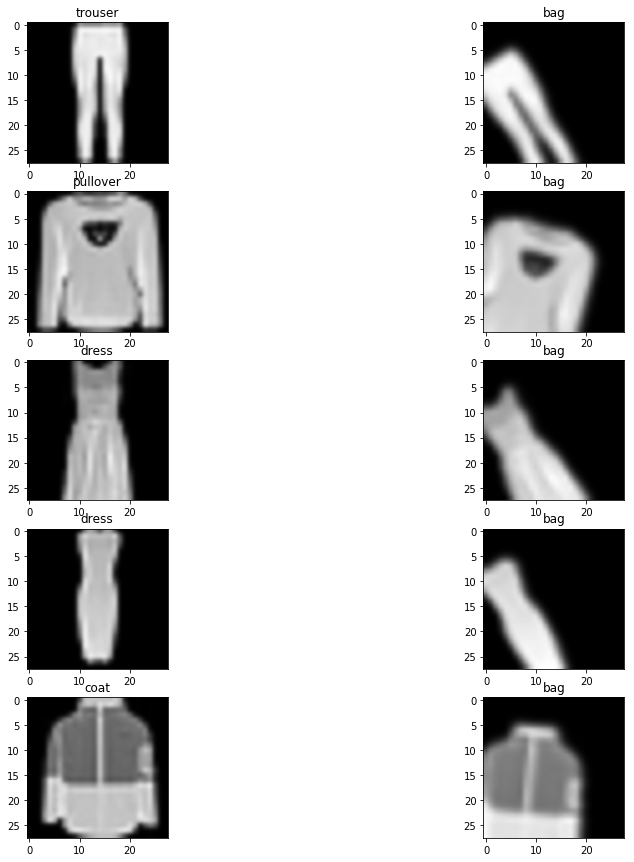

In [ ]:
x_adv = generate_adversarial_example(wrap, SpatialTransformationMethod)
adv_res = x_adv.eval(session=sess, feed_dict={model.input:x_train[:400]}) # Convert to numpy matrix
adv_results = model.predict_classes(adv_res)
clean_results = model.predict_classes(x_train[:400])
plot_n_examples(adv_res, clean_results, adv_results, n = 5)

### Projected Gradient Descent

/nfs/projects/cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_sum at 0x7f0c15d6ff28> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "


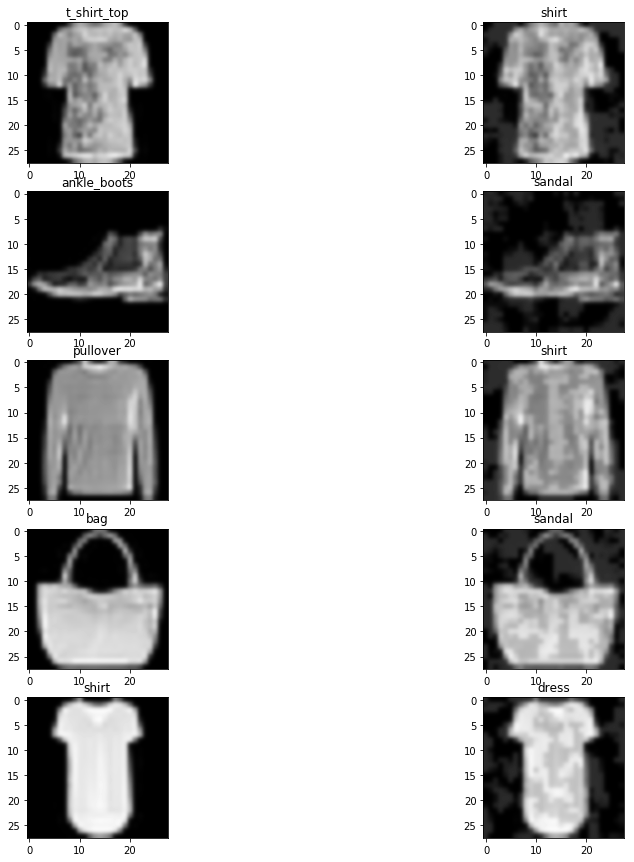

In [ ]:
params = dict(eps=0.1, eps_iter=0.05, nb_iter=10)
x_adv = generate_adversarial_example(wrap, ProjectedGradientDescent, **params)
adv_res = x_adv.eval(session=sess, feed_dict={model.input:x_train[:400]}) # Convert to numpy matrix
adv_results = model.predict_classes(adv_res)
clean_results = model.predict_classes(x_train[:400])
plot_n_examples(adv_res, clean_results, adv_results, n=5)

### DeepFool - (Not running it because it takes ages)

In [ ]:
# params = dict(nb_candidate=10,
#                    overshoot=0.02,
#                    max_iter=1)
# x_adv = generate_adversarial_example(wrap, DeepFool, **params)
# adv_res = x_adv.eval(session=sess, feed_dict={model.input:x_train[:1]}) # Convert to numpy matrix
# adv_results = model.predict_classes(adv_res)
# clean_results = model.predict_classes(x_train[:1])
# plot_n_examples(adv_res, clean_results, adv_results, n = 1)

# Adversarial Training

In [ ]:
def get_adversarial_loss(model, fgsm, fgsm_params):
    def adv_loss(y, preds):
        # Cross-entropy on the legitimate examples
        cross_ent = keras.losses.categorical_crossentropy(y, preds)

        # Generate adversarial examples
        x_adv = fgsm.generate(model.input, **fgsm_params)
        # Consider the attack to be constant
        x_adv = tf.stop_gradient(x_adv)

        # Cross-entropy on the adversarial examples
        preds_adv = model(x_adv)
        cross_ent_adv = keras.losses.categorical_crossentropy(y, preds_adv)

        return 0.5 * cross_ent + 0.5 * cross_ent_adv

    return adv_loss


###  Repeating the process, using adversarial training

In [10]:

learning_rate = LEARNING_RATE
nb_epochs = NB_EPOCHS
batch_size = BATCH_SIZE



print("Repeating the process, using adversarial training")
# Redefine Keras model
model_2 = cnn_model(img_rows=img_rows, img_cols=img_cols,
                    channels=nchannels, nb_filters=64,
                    nb_classes=nb_classes)
model_2(model_2.input)
wrap_2 = KerasModelWrapper(model_2)
fgsm_2 = FastGradientMethod(wrap_2, sess=sess)

# Use a loss function based on legitimate and adversarial examples
adv_loss_2 = get_adversarial_loss(model_2, fgsm_2, fgsm_params)
adv_acc_metric_2 = get_adversarial_acc_metric(model_2, fgsm_2, fgsm_params)
model_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=adv_loss_2,
    metrics=['accuracy', adv_acc_metric_2]
)

# Train an MNIST model
model_2.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=nb_epochs,
            validation_data=(x_test, y_test),
            verbose=2)

# Evaluate the accuracy on legitimate and adversarial test examples
_, acc, adv_acc = model_2.evaluate(x_test, y_test,
                                   batch_size=batch_size,
                                   verbose=0)
report.adv_train_clean_eval = acc
report.adv_train_adv_eval = adv_acc
print('Test accuracy on legitimate examples: %0.4f' % acc)
print('Test accuracy on adversarial examples: %0.4f\n' % adv_acc)


Repeating the process, using adversarial training


/nfs/projects/cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_max at 0x7f8f73c0dae8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
/nfs/projects/cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_sum at 0x7f8f73c0d2f0> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "


Train on 60000 samples, validate on 10000 samples
Epoch 1/6
 - 134s - loss: 1.2248 - acc: 0.7922 - adv_acc: 0.5391 - val_loss: 0.6771 - val_acc: 0.8303 - val_adv_acc: 0.7546
Epoch 2/6
 - 131s - loss: 0.8720 - acc: 0.8695 - adv_acc: 0.8097 - val_loss: 0.4780 - val_acc: 0.8770 - val_adv_acc: 0.8410
Epoch 3/6
 - 131s - loss: 0.7919 - acc: 0.8954 - adv_acc: 0.8621 - val_loss: 0.4293 - val_acc: 0.8934 - val_adv_acc: 0.8731
Epoch 4/6
 - 130s - loss: 0.7548 - acc: 0.9084 - adv_acc: 0.8843 - val_loss: 0.4351 - val_acc: 0.8993 - val_adv_acc: 0.8826
Epoch 5/6
 - 129s - loss: 0.7272 - acc: 0.9184 - adv_acc: 0.8988 - val_loss: 0.3925 - val_acc: 0.9065 - val_adv_acc: 0.8875
Epoch 6/6
 - 129s - loss: 0.7093 - acc: 0.9263 - adv_acc: 0.9068 - val_loss: 0.3693 - val_acc: 0.9062 - val_adv_acc: 0.8929
Test accuracy on legitimate examples: 0.9062
Test accuracy on adversarial examples: 0.8929



#### Test accuracy on **legitimate examples: 0.9062**

#### Test accuracy on **adversarial examples: 0.8929**
